In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP

np.random.seed(42)

/home/jake/miniconda3/envs/pc-eval/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_domains = 5
n_per_domain = 25
p = 10

# just have e_c and e_s be unit vectors
# e_c = np.array([1, 0])
# e_s = np.array([0, 1])

z = np.random.normal(size=(n_domains, p))
z

array([[ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
        -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004],
       [-0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
        -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ],
       [ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
         0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375],
       [-0.60170661,  1.85227818, -0.01349722, -1.05771093,  0.82254491,
        -1.22084365,  0.2088636 , -1.95967012, -1.32818605,  0.19686124],
       [ 0.73846658,  0.17136828, -0.11564828, -0.3011037 , -1.47852199,
        -0.71984421, -0.46063877,  1.05712223,  0.34361829, -1.76304016]])

In [3]:
betas = np.random.uniform(-1, 2, size=(n_domains,))
betas

array([-0.57722733,  1.40659094, -0.77634807,  1.96066081,  1.31673431])

In [4]:
xs = None
ys = None

for i, beta_i in enumerate(betas):
    ys_i = np.random.choice([-1, 1], size=(n_per_domain, 1))
    np.tile((np.array([beta_i]) @ z[[i], :]), (n_per_domain, 1))
    xs_i = (
        np.tile(ys_i, (1, p)) *
        np.tile((np.array([beta_i]) @ z[[i], :]), (n_per_domain, 1))
    ) + (np.random.normal(scale=2., size=(n_per_domain, p)))
    if xs is None:
        xs = xs_i
    else:
        xs = np.concatenate((xs, xs_i))
    if ys is None:
        ys = ys_i
    else:
        ys = np.concatenate((ys, ys_i))
    
print(xs.shape)
print(xs[:5, :5])

(125, 10)
[[ 2.65116559 -2.16798674  1.52614727  2.57389849  1.05092988]
 [-1.84612074 -1.60798279 -0.67493124 -2.81024979  0.43613788]
 [ 1.45869321  4.6542619   2.87197748  0.7683317   0.72127822]
 [ 2.21199956 -0.49919481 -1.17422234  0.15957816  1.31300678]
 [-2.33318439  5.8075169  -1.81866807  2.70890309 -1.46728097]]


In [5]:
print(ys.shape)
print(ys[:3, :])

(125, 1)
[[1]
 [1]
 [1]]


In [6]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs)

domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['domain'] = domains
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['domain'] = domains
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

,UMAP0,UMAP1,domain,label
0,8.526033,4.360017,0,1
1,9.067436,2.016167,0,1
2,9.181495,3.876685,0,1
3,9.194437,3.586769,0,-1
4,9.351715,2.956203,0,-1


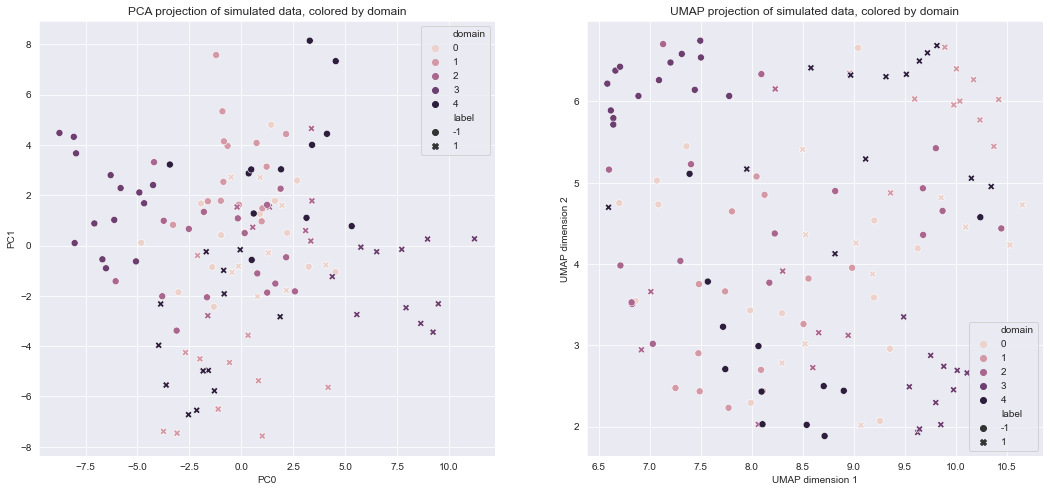

In [7]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='domain', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='domain', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection of simulated data, colored by domain')
axarr[1].set_xlabel('PC1')
axarr[1].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection of simulated data, colored by domain')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()